In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

from astropy.table import Table, vstack

import numpy as np 
import emcee

import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)
    
from asap.um_model_plot import plot_mtot_minn_smf, plot_dsigma_profiles
from asap.asap_data_io import parse_config, load_observed_data, \
    config_observed_data, config_um_data, load_um_data
from asap.asap_utils import mcmc_save_pickle, mcmc_save_results, \
    mcmc_initial_guess, mcmc_samples_stats, mcmc_save_results
from asap.asap_model_setup import setup_model
from asap.asap_likelihood import asap_flat_prior, asap_ln_like, asap_flat_prior_transform

from asap.asap_run_model import * 
from asap.asap_model_prediction import *
from asap.asap_likelihood import * 

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from numpy import linalg

import dynesty
from dynesty import plotting as dyplot

### Read the configuration and data

In [4]:
config_file = '../asap/asap_default_config.yaml'

cfg_ini = parse_config(config_file)

global cfg, obs_data, um_data

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin3_default
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_new.npy
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_new.npy
# Covariances for SMFs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_m10_cov.npy
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# There are 15 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.5000 -- 12.2000 in 7 bins
# SMF for inner stellar mass: 
  10.7000 -- 11.8000 in 11 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    11 bins at 10.70 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the HSC data is    102060083.62 Mpc^3
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


In [5]:
print(cfg.keys())

['um_min_scatter', 'param_ini', 'dynesty_maxiter_run', 'dynesty_maxiter_ini', 'dynesty_results_file', 'mcmc_out_dir', 'obs_smf_cov', 'obs_wl_sample', 'obs_omega_m', 'obs_smf_tot', 'obs_smf_full_fits', 'smf_tot_file', 'dynesty_nlive_run', 'um_mtot_nbin_min', 'dynesty_update_interval', 'param_sig', 'dynesty_bootstrap', 'mcmc_wl_only', 'mcmc_nsamples', 'dynesty_nlive_ini', 'um_model', 'obs_smf_inn', 'obs_h0', 'dynesty_maxcall_ini', 'obs_smf_full_file', 'obs_minn_col', 'um_wl_add_stellar', 'obs_dir', 'obs_area', 'um_redshift', 'dynesty_bound', 'obs_smf_inn_nbin', 'dynesty_maxcall_run', 'mcmc_wl_weight', 'um_wl_nbin', 'obs_cosmo', 'smf_cov_file', 'obs_volume', 'um_cosmo', 'obs_smf_inn_min', 'obs_cat', 'obs_smf_tot_nbin', 'mcmc_run_file', 'mcmc_prefix', 'mcmc_smf_only', 'mcmc_nthreads', 'obs_wl_n_bin', 'um_dir', 'obs_smf_tot_min', 'smf_inn_file', 'um_min_mvir', 'dynesty_dlogz_ini', 'mcmc_labels', 'um_lbox', 'um_mtot_nbin', 'um_wl_cat', 'param_upp', 'obs_z_col', 'um_omega_m', 'param_low', 'um

### Test flat prior transform

In [14]:
from prospect.models import priors

a = priors.TopHat(mini=-0.1, maxi=3.0)

In [41]:
unit_cube = np.random.random(cfg_ini['mcmc_ndims'])

asap_flat_prior_transform(unit_cube, cfg['param_low'], cfg['param_upp'])

array([ 0.58133591,  6.6947321 , -0.12088829,  0.06932583,  0.47029372,
        0.12406602])

### Test dynesty sampling

In [ ]:
sampler = dynesty.NestedSampler(asap_ln_like, 
                                asap_flat_prior_transform, 
                                cfg['mcmc_ndims'],
                                logl_args=[cfg, obs_data, um_data],
                                ptform_args=[cfg['param_low'], cfg['param_upp']],
                                bound='balls', nlive=1000,
                                bootstrap=50, enlarge=1.10,
                                update_interval=1.2)

In [ ]:
sampler.run_nested(dlogz=0.05, maxiter=100000)
res = sampler.results

iter: 6915 | bound: 94 | nc: 95 | ncall: 169487 | eff(%):  4.080 | loglstar:   -inf < -467.695 <    inf | logz: -479.598 +/-  0.107 | dlogz: 238.878 >  0.050                

In [60]:
res

         niter: 3001
        logvol: array([-9.99500333e-04, -1.99900067e-03, -2.99850100e-03, ...,
       -8.80964299e+00, -9.21510810e+00, -9.90825528e+00])
   information: array([13.40916979,  8.0907011 ,  4.89570725, ...,  9.67692083,
       10.60140246, 10.39350448])
    samples_id: array([618, 498, 449, ..., 619, 287, 232])
          logz: array([-5.08369775e+08, -3.32252462e+08, -3.19099253e+08, ...,
       -3.12551660e+02, -2.62616858e+02, -2.58781613e+02])
         bound: [<dynesty.bounding.UnitCube object at 0x116120110>]
         ncall: array([1, 1, 1, ..., 1, 1, 1])
 samples_bound: array([0, 0, 0, ..., 0, 0, 0])
         scale: array([1., 1., 1., ..., 1., 1., 1.])
         nlive: 1000
       samples: array([[ 3.44828527e-01,  7.96043026e+00, -3.50784120e-02,
         6.34020483e-03,  4.16133663e-01,  2.06873333e-01],
       [ 9.62021062e-01,  6.86380301e-01, -7.29680709e-03,
         2.20653323e-02,  6.80379508e-01,  2.54947582e-01],
       [ 3.53590697e-01,  7.83970892e+00

### Test Dynesty results

In [3]:
dynesty_test_result = 'test/asap_smdpl_mmax_m10_frac4_test_6_results.pkl'

import pickle 

res = pickle.load(open(dynesty_test_result, 'rb'))

In [4]:
res.summary()

Summary
nlive: 200
niter: 3848
ncall: 45089
eff(%):  8.978
logz: -183.957 +/-  0.266


In [14]:
np.argmax(res['logl'])

4047

In [17]:
(res['samples'])[4047]

array([ 0.60777711,  3.630604  , -0.00954931,  0.01686854,  0.58168844,
       -0.21767865,  0.038176  ])

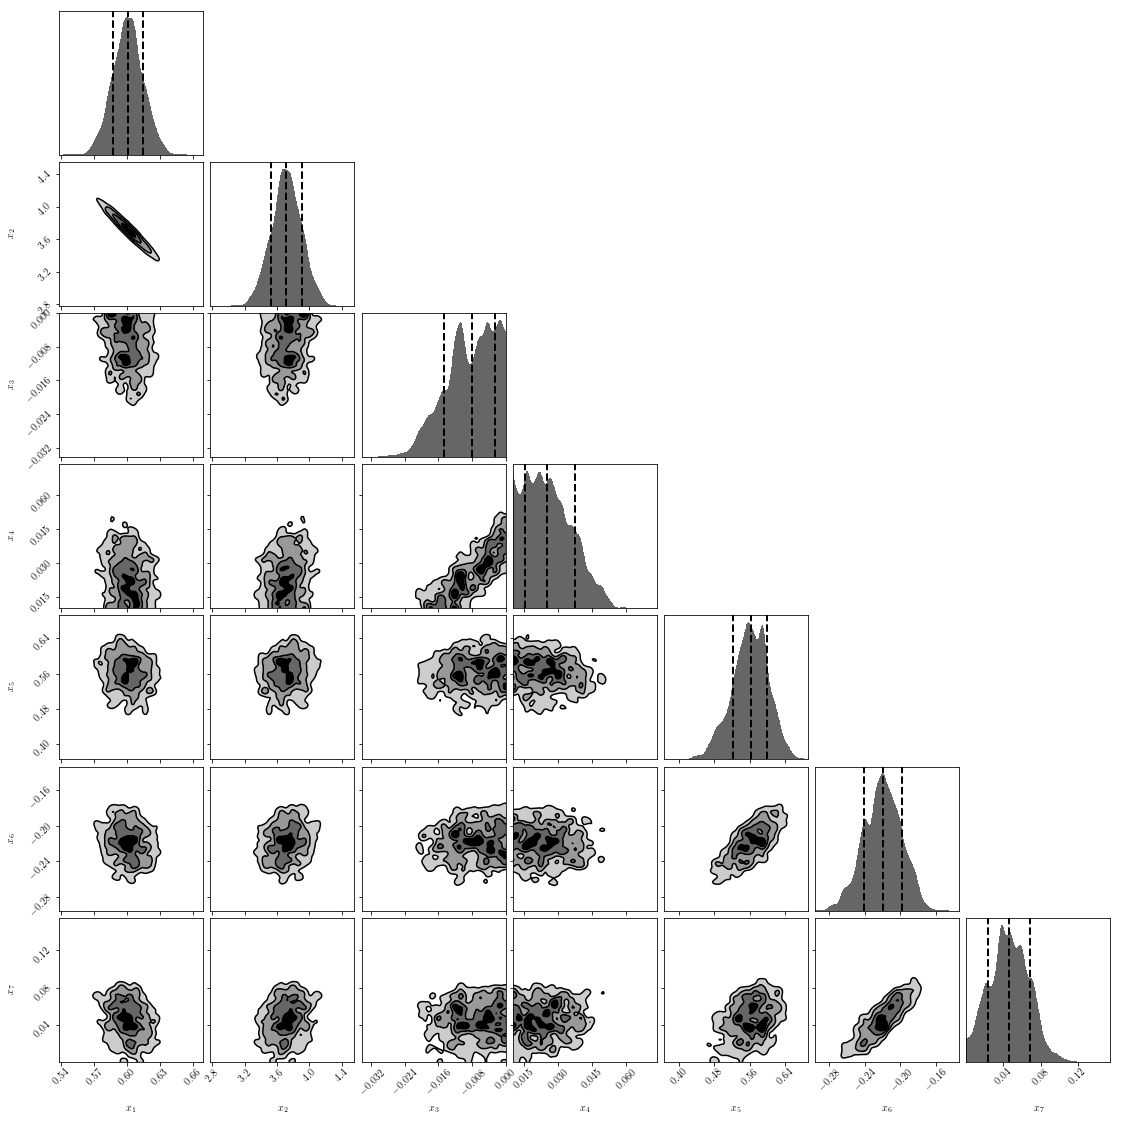

In [5]:
fig, axes = dyplot.cornerplot(res)

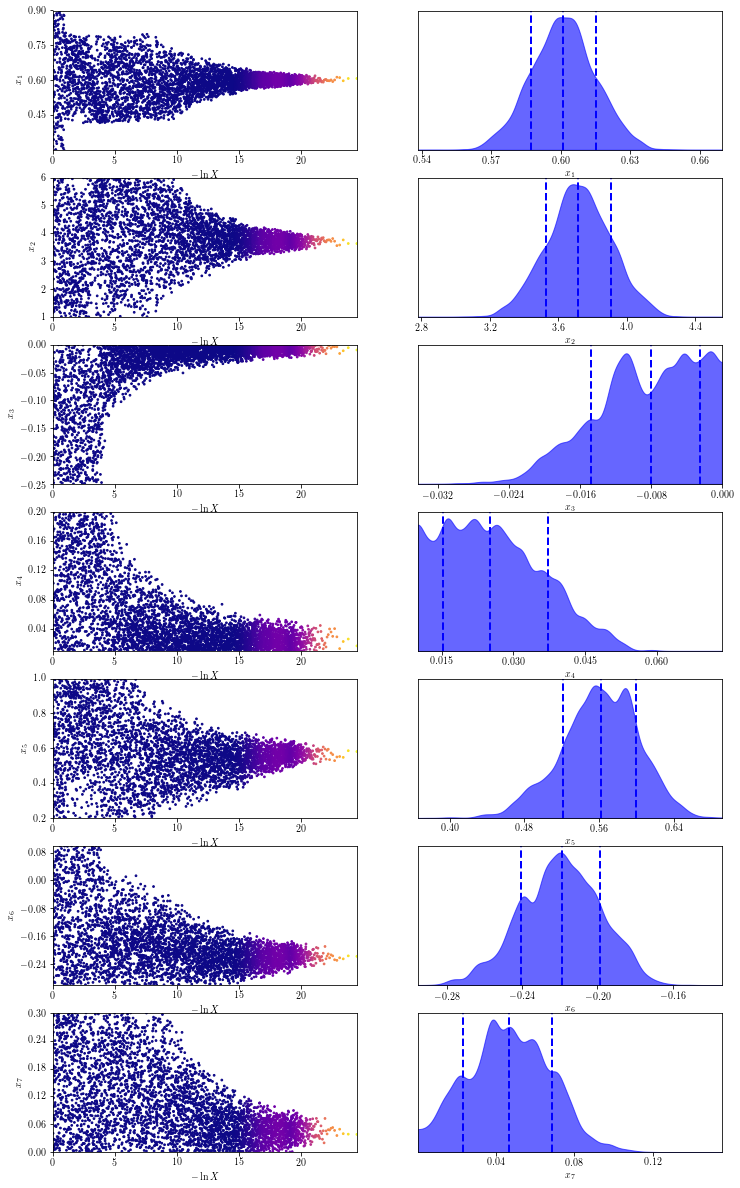

In [6]:
fig, axes = dyplot.traceplot(res)

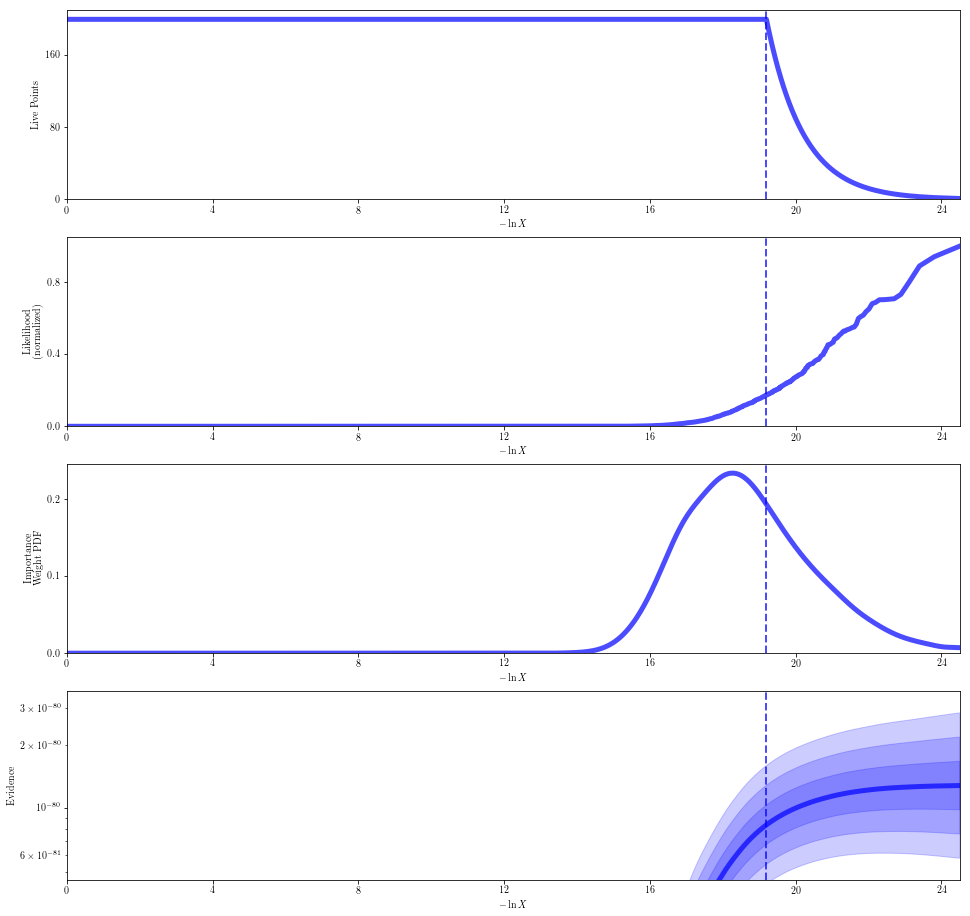

In [7]:
# Plot results.
fig, axes = dyplot.runplot(res, logplot=True)